In [1]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import INFO
import numpy as np
import faiss
import copy
from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [3]:
from base_models import * 

%load_ext autoreload
%autoreload 1

In [32]:
CHANNELS = 1
N_CLASSES = 2
N_EPOCHS = 10

# DATASET_NAME = "PneumoniaMNIST"
# DATASET_NAME = "DermaMNIST" 
# DATASET_ID = "dermamnist"
DATASET_NAME = "BreastMNIST"
DATASET_ID = "breastmnist" 

### Data Loading 

In [5]:
print(f"Step 1: Loading {DATASET_NAME} dataset with resize transform...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

info = INFO[DATASET_ID]
DataClass = getattr(__import__('medmnist'), info['python_class'])

device = torch.device('cuda:0')

train_dataset = DataClass(split='train', transform=transform, download=True, size=224)
val_dataset   = DataClass(split='val',   transform=transform, download=True, size=224)
test_dataset  = DataClass(split='test',  transform=transform, download=True, size=224)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Step 1: Loading BreastMNIST dataset with resize transform...
Train samples: 546, Validation samples: 78, Test samples: 156


In [33]:
def train_model(model_class, seed, epochs=10):
    torch.manual_seed(seed)
    model = model_class().to(device)
    print(f"\nTraining {model.__class__.__name__} with seed {seed} for {epochs} epochs...") 

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.squeeze().long().to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)

        avg_loss = total_loss / total
        accuracy = correct / total * 100
        print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return copy.deepcopy(model.to('cpu')) 

### Ensemble Models 

In [34]:
class SoftVotingEnsemble:
    def __init__(self, models, device='cpu'):
        self.models = models
        self.device = device
        for model in self.models:
            model.eval().to(device)

    def predict(self, images, return_probs=False):
        probs = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(images.to(self.device))
                softmaxed = torch.softmax(outputs, dim=1)
                probs.append(softmaxed.cpu().numpy())
        mean_probs = np.mean(np.stack(probs), axis=0)
        if return_probs:
            return mean_probs
        return np.argmax(mean_probs, axis=1)

    def predict_single_with_probs(self, image):
        image = image.unsqueeze(0)  # Shape [1, C, H, W]
        with torch.no_grad():
            model_probs = []
            for model in self.models:
                logits = model(image.to(self.device))
                softmaxed = torch.softmax(logits, dim=1)
                model_probs.append(softmaxed.cpu().numpy())
            mean_probs = np.mean(np.stack(model_probs), axis=0)
            probs = mean_probs[0]
            pred = np.argmax(probs)
            return probs, pred

### Define DESImage 

In [89]:
from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import numpy as np
import faiss
from torch.utils.data import DataLoader
from tqdm import tqdm
import clip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import torch
import torch.nn as nn

def get_last_linear_layer(model):
    """
    Try to find the last Linear layer in the model,
    using common attribute names and fallback to scanning modules.
    """
    name = model.__class__.__name__.lower()

    # Common last layer attribute names to try (ViT, EfficientNet, etc)
    candidate_attrs = ['head', 'heads', 'classifier', 'fc', 'mlp_head']

    for attr in candidate_attrs:
        if hasattr(model, attr):
            layer = getattr(model, attr)
            # If it's directly a Linear layer
            if isinstance(layer, nn.Linear):
                return layer
            # If Sequential or Module, find last Linear inside it
            if isinstance(layer, nn.Sequential) or isinstance(layer, nn.Module):
                # Find last Linear inside this attribute recursively
                last_linear = None
                for child in reversed(list(layer.modules())):
                    if isinstance(child, nn.Linear):
                        last_linear = child
                        break
                if last_linear is not None:
                    return last_linear

    # Fallback: scan all modules and pick the last Linear
    last_linear = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last_linear = m
    if last_linear is not None:
        return last_linear

    raise RuntimeError("No Linear layer found in model")


def get_features_before_last_linear(model, x):
    features = {}

    def find_last_linear(module):
        last_linear = None
        for m in module.modules():
            if isinstance(m, torch.nn.Linear):
                last_linear = m
        return last_linear

    last_linear = find_last_linear(model)
    if last_linear is None:
        raise RuntimeError("No Linear layer found in model")

    def hook(module, input, output):
        features['feat'] = input[0].detach()

    handle = last_linear.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        _ = model(x)

    handle.remove()

    if 'feat' not in features:
        raise RuntimeError("Failed to capture features from last linear layer")

    return features['feat']
    

class DESImage: 
    def __init__(self, dsel_dataset, pool): 
        self.dsel_dataset = dsel_dataset
        self.dsel_loader = DataLoader(dsel_dataset, batch_size=64, shuffle=False) 
        self.dino_model = timm.create_model('vit_base_patch16_224.dino', pretrained=True).to(device)
        self.dino_model.eval()  
        self.pool = pool 

        self.suspected_model_votes = [] 
        
        
    def dino_embedder(self, images):
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        return self.dino_model.forward_features(images)
        

    def fit(self): 
        dsel_embeddings = []
        dsel_labels = []
    
        with torch.no_grad():
            for imgs, labels in self.dsel_loader:
                imgs = imgs.to(device)
                embs = self.dino_embedder(imgs).cpu()  # shape: [B, seq_len, 768]
                dsel_embeddings.append(embs)
                dsel_labels.append(labels)
    
        # Keep as tensor
        dsel_embeddings_tensor = torch.cat(dsel_embeddings).detach().cpu()  # shape: [N, seq_len, 768]
        cls_tensor = dsel_embeddings_tensor[:, 0, :]  # CLS token only, shape: [N, 768]
    
        # Convert to NumPy
        cls_embeddings = np.ascontiguousarray(cls_tensor.numpy(), dtype='float32')
        self.dsel_embeddings = cls_embeddings
        self.dsel_labels = torch.cat(dsel_labels).numpy()
    
        # Sanity check
        print(type(cls_embeddings))  # should be <class 'numpy.ndarray'>
        print(cls_embeddings.dtype)  # float32
        print(cls_embeddings.flags['C_CONTIGUOUS'])  # True
    
        # Build FAISS index
        embedding_dim = cls_embeddings.shape[1]
        self.index = faiss.IndexFlatL2(embedding_dim)
        self.index.add(cls_embeddings)
        

    def visualize_test_and_roc(self, test_img, roc_imgs, local_labels, class_names=None):
        def denormalize(img_tensor, mean, std):
            mean = torch.tensor(mean).view(-1, 1, 1).to(img_tensor.device)
            std = torch.tensor(std).view(-1, 1, 1).to(img_tensor.device)
            return img_tensor * std + mean
        """
        Display test image and its Region of Competence (RoC) images with labels.
        
        Args:
            test_img (torch.Tensor): Shape (C, H, W)
            roc_imgs (torch.Tensor): Shape (k, C, H, W)
            local_labels (np.ndarray): Shape (k,)
            class_names (list): Optional list of class names
        """
        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225] 

        k = roc_imgs.size(0)
        ncols = min(k, 5)
        nrows = 1 + (k + ncols - 1) // ncols  # one row for test image + RoC images
    
        plt.figure(figsize=(3 * ncols, 3 * nrows))
    
        # Plot test image
        plt.subplot(nrows, ncols, 1)
        denorm_img = denormalize(test_img, mean, std).clamp(0, 1)
        img_np = TF.to_pil_image(denorm_img.cpu())
        plt.imshow(img_np)
        plt.title("Test Image")
        plt.axis("off")
    
        # Plot RoC images
        for i in range(k):
            plt.subplot(nrows, ncols, i + 2)
            denorm_img = denormalize(roc_imgs[i], mean, std).clamp(0, 1)
            img_np = TF.to_pil_image(denorm_img.cpu())
            label = local_labels[i]
            if class_names:
                label = class_names[label]
            plt.imshow(img_np)
            plt.title(f"RoC #{i+1}\nLabel: {label}")
            plt.axis("off")
    
        plt.tight_layout()
        plt.show()


    def get_output_size(self, model):
        """
        Returns the output size (number of classes) from various model architectures.
        """
        if hasattr(model, 'fc'):
            return model.fc.out_features
        elif hasattr(model, 'classifier'):
            if isinstance(model.classifier, nn.Sequential):
                return model.classifier[-1].out_features
            else:
                return model.classifier.out_features
        elif hasattr(model, 'heads'):  # ViT / DINO from torchvision
            return model.heads.head.out_features
        elif hasattr(model, 'head'):  # ViT/Swin from timm
            return model.head.out_features
        else:
            raise AttributeError("Cannot determine output size of the model.")


    def print_attack_statistics(self):
        if not self.suspected_model_votes:
            print("No predictions made yet.")
            return
    
        total = len(self.suspected_model_votes)
        count = Counter(self.suspected_model_votes)
        print("\n Suspected Attacked Model Statistics:")
        for model_idx, votes in count.items():
            percent = 100.0 * votes / total
            print(f" - Model #{model_idx}: {votes}/{total} ({percent:.2f}%)")
            print(f" Suspected attacked model name: {self.pool[model_idx].__class__.__name__}")
    
        
    
    def predict_weighted_robust(self, test_img, k=7, return_logits=False, explain=False):
        # Step 1: Get DINO CLS embedding for the test image
        img_for_dino = test_img.unsqueeze(0).to(device)
        if img_for_dino.shape[1] == 1:
            img_for_dino = img_for_dino.repeat(1, 3, 1, 1)
        with torch.no_grad():
            test_emb = self.dino_model.forward_features(img_for_dino).cpu().numpy().astype('float32')
            test_emb = test_emb[:, 0, :]  # CLS token only
    
        # Step 2: Find k nearest neighbors in FAISS (Region of Competence)
        _, neighbors = self.index.search(test_emb, k)
        neighbor_idxs = neighbors[0]
        local_labels = self.dsel_labels[neighbor_idxs]
        local_labels = np.array(local_labels).flatten()
    
        # Step 3: Get RoC images
        with torch.no_grad():
            roc_imgs = torch.stack([self.dsel_dataset[idx][0] for idx in neighbor_idxs]).to(device)
    
        # Step 4: Evaluate classifiers — compute competence and feature similarity
        competences = []
        feature_similarities = []
        soft_outputs = []
    
        test_img_batch = test_img.unsqueeze(0).to(device)
    
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                outputs = clf(roc_imgs)
                preds = outputs.argmax(dim=1).cpu().numpy()
                correct = (preds == local_labels).sum()
                competence = correct / k
                competences.append(competence)

                logits = clf(test_img.unsqueeze(0).to(device)).squeeze(0)
                probs = softmax(logits, dim=0)
                soft_outputs.append(probs)

                # Feature similarity using ResNet embeddings
                test_feat = get_features_before_last_linear(clf, test_img.unsqueeze(0).to(device))
                roc_feats = get_features_before_last_linear(clf, roc_imgs)
                mean_feat = roc_feats.mean(dim=0, keepdim=True)

                sim = cosine_similarity(test_feat / test_feat.norm(), mean_feat / mean_feat.norm(), dim=1)
                feature_similarities.append(sim.item())
    
        # Step 5: Combine competence & feature similarity into a score
        alpha = 1.0  # adjust influence of similarity
        combined_scores = [c * (s / alpha) for c, s in zip(competences, feature_similarities)]
    
        # Step 6: Normalize to get weights
        total_score = sum(combined_scores)
        if total_score == 0:
            weights = [1.0 / len(self.pool)] * len(self.pool)
        else:
            weights = [s / total_score for s in combined_scores]
    
        # Step 7: Weighted aggregation of classifier outputs
        num_classes = self.get_output_size(self.pool[0].model)
        weighted_logits = torch.zeros(num_classes).to(device)
        for prob, weight in zip(soft_outputs, weights):
            weighted_logits += weight * prob
    
        # Step 8: Keep track of suspected attacked model
        min_sim_idx = int(np.argmin(feature_similarities))
        self.suspected_model_votes.append(min_sim_idx)

        # Step 8: Optional explainability
        if explain:
            print("\nExplainability Report:")
            for idx, (clf, comp, sim, weight, prob) in enumerate(zip(self.pool, competences, feature_similarities, weights, soft_outputs)):
                pred_class = prob.argmax().item()
                conf = prob[pred_class].item()
                topk = torch.topk(prob, k=2)
                print(f"Model #{idx}: {clf.__class__.__name__}")
                print(f"  - Competence: {comp:.4f}")
                print(f"  - Feature similarity: {sim:.4f}")
                print(f"  - Combined weight: {weight:.4f}")
                print(f"  - Predicted class: {pred_class} with confidence {conf:.4f}")
                print(f"  - Top-5: {topk.indices.tolist()} → {[round(p.item(), 3) for p in topk.values]}")
                print("-" * 50)
    
            print(f"\n🧠 Final prediction: {weighted_logits.argmax().item()}")
            top5 = torch.topk(weighted_logits, k=2)
            print(f"🔝 Top-5 predictions:")
            for i in range(2):
                print(f"  - Class {top5.indices[i].item()}: {top5.values[i].item():.4f}")
    
            print("\nModel weight distribution:")
            for idx, w in enumerate(weights):
                print(f"  Model #{idx}: {w:.4f}")
            print(f"Suspected attacked model: Model #{min_sim_idx} ({self.pool[min_sim_idx].__class__.__name__})")
    
            print("\nRoC visualization:")
            self.visualize_test_and_roc(test_img.squeeze(0), roc_imgs, local_labels)
    
        if return_logits:
            return weighted_logits
        return weighted_logits.argmax().item()



In [90]:
des_model = DESImage(val_dataset, pool)
des_model.fit()

<class 'numpy.ndarray'>
float32
True



Explainability Report:
Model #0: ResNet50Classifier
  - Competence: 1.0000
  - Feature similarity: 0.4438
  - Combined weight: 0.1949
  - Predicted class: 0 with confidence 1.0000
  - Top-5: [0, 1] → [1.0, 0.0]
--------------------------------------------------
Model #1: MobileNetV2Classifier
  - Competence: 1.0000
  - Feature similarity: 0.1299
  - Combined weight: 0.0571
  - Predicted class: 0 with confidence 1.0000
  - Top-5: [0, 1] → [1.0, 0.0]
--------------------------------------------------
Model #2: DenseNet201Classifier
  - Competence: 1.0000
  - Feature similarity: 0.9551
  - Combined weight: 0.4194
  - Predicted class: 1 with confidence 1.0000
  - Top-5: [1, 0] → [1.0, 0.0]
--------------------------------------------------
Model #3: GoogLeNetClassifier
  - Competence: 1.0000
  - Feature similarity: 0.7483
  - Combined weight: 0.3286
  - Predicted class: 1 with confidence 0.7663
  - Top-5: [1, 0] → [0.766, 0.234]
--------------------------------------------------

🧠 Final 

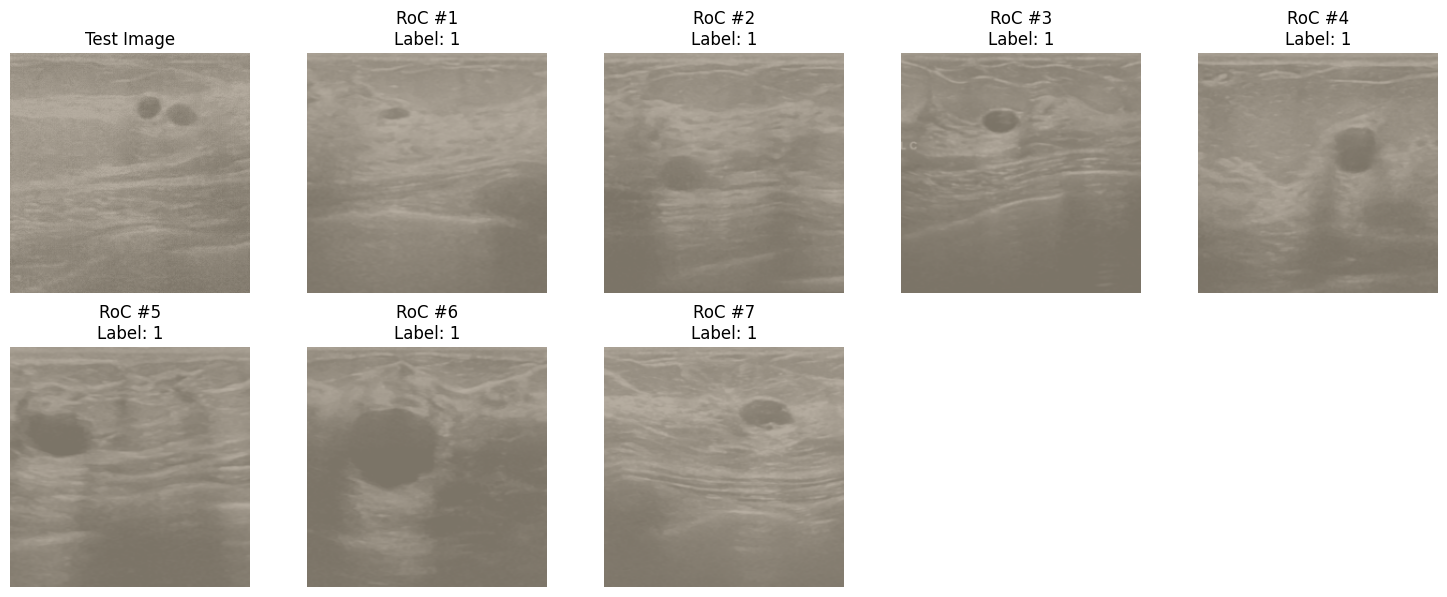

1

In [92]:
index = 55

# print(f"True class: {test_set[index][1]}") 

des_model.predict_weighted_robust(adv_dataset_2[2][0], explain=True)

In [36]:
np.exp(1 * 0.5) 

np.float64(1.6487212707001282)

In [37]:
np.exp(1 * 0.9)  

np.float64(2.45960311115695)

### Benchmark 

In [38]:
from torch.utils.data import TensorDataset, DataLoader
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from collections import defaultdict


def evaluate_classifiers(pool, test_dataset, n_classes):
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    results = []

    for i, model in enumerate(pool):
        model = model.to(device)
        model.eval()
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.squeeze().long().to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                probs = torch.softmax(outputs, dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(probs.cpu().numpy())

        acc = (np.array(y_true) == np.array(y_pred)).mean() * 100
        f1 = f1_score(y_true, y_pred, average='macro') * 100
        try:
            auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
        except ValueError:
            auc = float('nan')  # Handle single-class test sets

        results.append({
            'classifier': model.__class__.__name__,
            'accuracy': acc,
            'f1': f1,
            'auc': auc,
        })

    return results

In [39]:
SEEDS = [10, 33, 45, 67, 85, 99, 102, 129, 141, 167] 
SEEDS = [10, 33, 45, 67, 85]

trained_pool = {} 

for seed in SEEDS: 
    print(f"\n--- Seed: {seed} ---")
    trained_resnet18 = train_model(lambda: ResNet18Classifier(N_CLASSES, CHANNELS).to(device), seed, N_EPOCHS) 
    trained_resnet34 = train_model(lambda: ResNet34Classifier(N_CLASSES, CHANNELS).to(device), seed, N_EPOCHS) 
    trained_resnet50 = train_model(lambda: ResNet50Classifier(N_CLASSES, CHANNELS), seed, N_EPOCHS) 
    trained_mobilenetv2 = train_model(lambda: MobileNetV2Classifier(N_CLASSES, CHANNELS).to(device), seed, N_EPOCHS) 
    trained_efficientnet = train_model(lambda: EfficientNetB0Classifier(N_CLASSES, CHANNELS), seed, N_EPOCHS) 
    trained_densenet201 = train_model(lambda: DenseNet201Classifier(N_CLASSES, CHANNELS), seed, N_EPOCHS)  
    trained_shufflenet = train_model(lambda: ShuffleNetClassifier(N_CLASSES, CHANNELS), seed, N_EPOCHS)
    trained_googlenet = train_model(lambda:GoogLeNetClassifier(N_CLASSES, CHANNELS), seed, N_EPOCHS) 
    trained_vit_b_16 = train_model(lambda:ViTClassifier(N_CLASSES, CHANNELS), seed, N_EPOCHS)  

    trained_pool[seed] = [
        trained_resnet18, 
        trained_resnet34, 
        trained_resnet50, 
        trained_mobilenetv2,
        trained_efficientnet, 
        trained_densenet201,
        trained_shufflenet,
        trained_googlenet,
        trained_vit_b_16
    ]


--- Seed: 10 ---

Training ResNet18Classifier with seed 10 for 10 epochs...
Epoch 1/10 - Loss: 0.7066, Accuracy: 68.68%
Epoch 2/10 - Loss: 0.3269, Accuracy: 87.55%
Epoch 3/10 - Loss: 0.2436, Accuracy: 91.03%
Epoch 4/10 - Loss: 0.1636, Accuracy: 92.86%
Epoch 5/10 - Loss: 0.0945, Accuracy: 97.44%
Epoch 6/10 - Loss: 0.0343, Accuracy: 98.90%
Epoch 7/10 - Loss: 0.0439, Accuracy: 98.72%
Epoch 8/10 - Loss: 0.0259, Accuracy: 99.45%
Epoch 9/10 - Loss: 0.0275, Accuracy: 98.72%
Epoch 10/10 - Loss: 0.0307, Accuracy: 98.90%

Training ResNet34Classifier with seed 10 for 10 epochs...
Epoch 1/10 - Loss: 0.7864, Accuracy: 71.61%
Epoch 2/10 - Loss: 0.3282, Accuracy: 86.81%
Epoch 3/10 - Loss: 0.2637, Accuracy: 89.01%
Epoch 4/10 - Loss: 0.1820, Accuracy: 93.22%
Epoch 5/10 - Loss: 0.1475, Accuracy: 94.51%
Epoch 6/10 - Loss: 0.2183, Accuracy: 91.58%
Epoch 7/10 - Loss: 0.1227, Accuracy: 95.24%
Epoch 8/10 - Loss: 0.0730, Accuracy: 97.62%
Epoch 9/10 - Loss: 0.0542, Accuracy: 98.35%
Epoch 10/10 - Loss: 0.0304,

In [40]:
def predict_for_ensembles(ensemble_model, test_loader, ens_type): 
    metrics = {
        'accuracy': [],
        'f1': [],
        'auc': []
    } 
    y_true, y_pred, y_prob = [], [], [] 

    for imgs, labels in tqdm(test_loader):
        img = imgs[0]
        label = labels.item()

        if ens_type == "soft": 
            probs, pred = ensemble_model.predict_single_with_probs(img)
        if ens_type == "des": 
            logits = ensemble_model.predict_weighted(img, return_logits=True)
            probs = torch.softmax(logits, dim=0).cpu().numpy()
            pred = np.argmax(probs)
        if ens_type == "des+": 
            logits = ensemble_model.predict_weighted_robust(img, return_logits=True)
            probs = torch.softmax(logits, dim=0).cpu().numpy()
            pred = np.argmax(probs)
    
        y_true.append(label)
        y_pred.append(pred)
        y_prob.append(probs)

    # Compute metrics
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='macro') * 100
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr') * 100
    except:
        auc = float('nan')

    print(f"{ens_type} Accuracy: {acc:.2f}%  | F1: {f1:.2f}%  | AUC: {auc:.2f}%")

    metrics['accuracy'].append(acc)
    metrics['f1'].append(f1)
    metrics['auc'].append(auc) 
    # print(y_prob)

    return metrics

In [93]:
import time
# from static_models import * 

SEEDS = [10, 33, 45, 67, 85, 99, 102, 129, 141, 167] 
SEEDS = [10, 33, 45, 67, 85] 

total_start = time.time()  # ⏱️ Start timing 

selected_pool_indices = [2, 3, 5, 7]
TARGET_MODEL_INDEX = 0
TARGET_MODEL_INDEX_2 = 1 
EPSILON = 0.05

all_results = defaultdict(list) 

attacked_results = defaultdict(list)
soft_voting_metrics = [] 
des_plus_metrics = [] 
soft_voting_metrics_attacked = [] 
des_plus_metrics_attacked = [] 

for seed in SEEDS: 
    print(f"\n--- Seed: {seed} ---")

    pool = [trained_pool[seed][i] for i in selected_pool_indices] 

    seed_results = evaluate_classifiers(pool, test_dataset, N_CLASSES)

    for res in seed_results:
        all_results[res['classifier']].append(res)


    # Build DES model
    des_model = DESImage(val_dataset, pool)
    des_model.fit()
    # des_metrics = predict_for_ensembles(des_model, test_loader, "des") 

    # Soft Voting 
    soft_ensemble = SoftVotingEnsemble(models=pool, device='cuda')  
    soft_voting_metrics.append(predict_for_ensembles(soft_ensemble, test_loader, "soft")) 

    des_plus_metrics.append(predict_for_ensembles(des_model, test_loader, "des+"))   

    ### Attack =============================================================================================
    print("Attacked")
    target_model = pool[TARGET_MODEL_INDEX]  
    target_model = target_model.to(device).eval() 

    dummy_optimizer = torch.optim.Adam(target_model.parameters())
    loss_fn = nn.CrossEntropyLoss() 

    # Wrap it for ART
    art_classifier = PyTorchClassifier(
        model=target_model,
        loss=loss_fn,
        optimizer=dummy_optimizer,
        input_shape=(1, 224, 224),  
        nb_classes=N_CLASSES,
        clip_values=(0.0, 1.0),
    )

    x_test = []
    y_test = []
    
    for img, label in test_dataset:
        x_test.append(img.numpy())
        y_test.append(label.item())
    
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    pgd_attack = ProjectedGradientDescent(estimator=art_classifier, eps=EPSILON, eps_step=0.01, max_iter=100)
    x_test_adv = pgd_attack.generate(x=x_test)

    adv_tensor = torch.tensor(x_test_adv).float()
    labels_tensor = torch.tensor(y_test).long()
    adv_dataset = TensorDataset(adv_tensor, labels_tensor)

    adv_test_loader = DataLoader(adv_dataset, batch_size=1, shuffle=False)  


    print("Attacked")
    target_model = pool[TARGET_MODEL_INDEX_2]  
    target_model = target_model.to(device).eval() 

    dummy_optimizer = torch.optim.Adam(target_model.parameters())
    loss_fn = nn.CrossEntropyLoss() 

    # Wrap it for ART
    art_classifier = PyTorchClassifier(
        model=target_model,
        loss=loss_fn,
        optimizer=dummy_optimizer,
        input_shape=(1, 224, 224),  
        nb_classes=N_CLASSES,
        clip_values=(0.0, 1.0),
    )

    pgd_attack = ProjectedGradientDescent(estimator=art_classifier, eps=EPSILON, eps_step=0.01, max_iter=100)
    x_test_adv_2 = pgd_attack.generate(x=x_test_adv)

    adv_tensor = torch.tensor(x_test_adv_2).float()
    labels_tensor = torch.tensor(y_test).long()
    adv_dataset_2 = TensorDataset(adv_tensor, labels_tensor)

    adv_test_loader_2 = DataLoader(adv_dataset_2, batch_size=1, shuffle=False) 

    

    seed_attack_results = evaluate_classifiers(pool, adv_dataset_2, N_CLASSES) 
    for res in seed_attack_results:
        attacked_results[res['classifier']].append(res)


    # Soft Voting Atacked 
    soft_ensemble = SoftVotingEnsemble(models=pool, device='cuda')  
    soft_voting_metrics_attacked.append(predict_for_ensembles(soft_ensemble, adv_test_loader_2, "soft")) 

    des_plus_metrics_attacked.append(predict_for_ensembles(des_model, adv_test_loader_2, "des+"))    
    

total_end = time.time()
print(f"\n⏱️ Total time for all seeds: {(total_end - total_start) / 60:.2f} minutes")


--- Seed: 10 ---
<class 'numpy.ndarray'>
float32
True


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 24.99it/s]


soft Accuracy: 89.74%  | F1: 85.83%  | AUC: nan%


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


des+ Accuracy: 87.82%  | F1: 83.01%  | AUC: nan%
Attacked


PGD - Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Attacked


PGD - Batches:   0%|          | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.00it/s]


soft Accuracy: 18.59%  | F1: 18.59%  | AUC: nan%


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.97it/s]


des+ Accuracy: 76.92%  | F1: 61.88%  | AUC: nan%

--- Seed: 33 ---
<class 'numpy.ndarray'>
float32
True


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 24.73it/s]


soft Accuracy: 89.74%  | F1: 86.32%  | AUC: nan%


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


des+ Accuracy: 89.10%  | F1: 85.34%  | AUC: nan%
Attacked


PGD - Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Attacked


PGD - Batches:   0%|          | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 24.89it/s]


soft Accuracy: 26.92%  | F1: 25.15%  | AUC: nan%


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.98it/s]


des+ Accuracy: 64.74%  | F1: 60.88%  | AUC: nan%

--- Seed: 45 ---
<class 'numpy.ndarray'>
float32
True


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.01it/s]


soft Accuracy: 83.33%  | F1: 73.17%  | AUC: nan%


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  6.00it/s]


des+ Accuracy: 82.69%  | F1: 73.15%  | AUC: nan%
Attacked


PGD - Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Attacked


PGD - Batches:   0%|          | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 24.81it/s]


soft Accuracy: 18.59%  | F1: 18.51%  | AUC: nan%


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.01it/s]


des+ Accuracy: 72.44%  | F1: 56.19%  | AUC: nan%

--- Seed: 67 ---
<class 'numpy.ndarray'>
float32
True


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 24.91it/s]


soft Accuracy: 89.74%  | F1: 87.51%  | AUC: nan%


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.00it/s]


des+ Accuracy: 89.10%  | F1: 86.45%  | AUC: nan%
Attacked


PGD - Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Attacked


PGD - Batches:   0%|          | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.09it/s]


soft Accuracy: 15.38%  | F1: 15.26%  | AUC: nan%


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.00it/s]


des+ Accuracy: 54.49%  | F1: 53.48%  | AUC: nan%

--- Seed: 85 ---
<class 'numpy.ndarray'>
float32
True


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 24.25it/s]


soft Accuracy: 89.10%  | F1: 85.83%  | AUC: nan%


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.92it/s]


des+ Accuracy: 88.46%  | F1: 84.87%  | AUC: nan%
Attacked


PGD - Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Attacked


PGD - Batches:   0%|          | 0/5 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 25.05it/s]


soft Accuracy: 25.00%  | F1: 23.02%  | AUC: nan%


100%|█████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.99it/s]

des+ Accuracy: 65.38%  | F1: 62.39%  | AUC: nan%

⏱️ Total time for all seeds: 10.28 minutes


In [94]:
import pandas as pd 

summary = []

for clf_name, metrics_list in all_results.items():
    accs = [m['accuracy'] for m in metrics_list]
    f1s = [m['f1'] for m in metrics_list]
    aucs = [m['auc'] for m in metrics_list]

    summary.append({
        'Classifier': clf_name,
        'Accuracy': f"{np.mean(accs):.2f} ± {np.std(accs):.2f}",
        'F1': f"{np.mean(f1s):.2f} ± {np.std(f1s):.2f}",
        'AUC': f"{np.mean(aucs):.2f} ± {np.std(aucs):.2f}",
    })

df_summary = pd.DataFrame(summary)
print(df_summary)

              Classifier      Accuracy             F1        AUC
0     ResNet50Classifier  85.00 ± 2.71   79.87 ± 4.49  nan ± nan
1  MobileNetV2Classifier  84.74 ± 5.02   79.89 ± 6.11  nan ± nan
2  DenseNet201Classifier  84.10 ± 4.79  76.47 ± 12.54  nan ± nan
3    GoogLeNetClassifier  84.36 ± 3.36   77.98 ± 7.49  nan ± nan


In [95]:
soft_voting_metrics

[{'accuracy': [89.74358974358975], 'f1': [85.82784465137406], 'auc': [nan]},
 {'accuracy': [89.74358974358975], 'f1': [86.32478632478633], 'auc': [nan]},
 {'accuracy': [83.33333333333334], 'f1': [73.17460317460318], 'auc': [nan]},
 {'accuracy': [89.74358974358975], 'f1': [87.50750750750751], 'auc': [nan]},
 {'accuracy': [89.1025641025641], 'f1': [85.8265191598525], 'auc': [nan]}]

In [96]:
import pandas as pd

summary = {
    'Metric': [],
    'Mean ± Std': []
}

for metric in ['accuracy', 'f1', 'auc']:
    values =  [m[metric] for m in soft_voting_metrics] 
    mean = np.nanmean(values)
    std = np.nanstd(values)
    summary['Metric'].append(metric.upper())
    summary['Mean ± Std'].append(f"{mean:.2f} ± {std:.2f}")

df_summary = pd.DataFrame(summary)
print("\n=== Final SOFT Performance (across seeds) ===")
print(df_summary)


=== Final SOFT Performance (across seeds) ===
     Metric    Mean ± Std
0  ACCURACY  88.33 ± 2.51
1        F1  83.73 ± 5.31
2       AUC     nan ± nan


In [97]:
import pandas as pd

summary = {
    'Metric': [],
    'Mean ± Std': []
}

for metric in ['accuracy', 'f1', 'auc']:
    values =  [m[metric] for m in des_plus_metrics] 
    mean = np.nanmean(values)
    std = np.nanstd(values)
    summary['Metric'].append(metric.upper())
    summary['Mean ± Std'].append(f"{mean:.2f} ± {std:.2f}")

df_summary = pd.DataFrame(summary)
print("\n=== Final DES+ Performance (across seeds) ===")
print(df_summary)


=== Final DES+ Performance (across seeds) ===
     Metric    Mean ± Std
0  ACCURACY  87.44 ± 2.42
1        F1  82.57 ± 4.84
2       AUC     nan ± nan


# <div style="color:white;display:fill;border-radius:5px;background-color:#f02263;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b></b> Adversarial Attack Results</p></div>

In [98]:
import pandas as pd 

summary = []

for clf_name, metrics_list in attacked_results.items():
    accs = [m['accuracy'] for m in metrics_list]
    f1s = [m['f1'] for m in metrics_list]
    aucs = [m['auc'] for m in metrics_list]

    summary.append({
        'Classifier': clf_name,
        'Accuracy': f"{np.mean(accs):.2f} ± {np.std(accs):.2f}",
        'F1': f"{np.mean(f1s):.2f} ± {np.std(f1s):.2f}",
        'AUC': f"{np.mean(aucs):.2f} ± {np.std(aucs):.2f}",
    })

df_summary = pd.DataFrame(summary)
print(df_summary)

              Classifier      Accuracy            F1        AUC
0     ResNet50Classifier  15.00 ± 2.71  14.73 ± 2.49  nan ± nan
1  MobileNetV2Classifier  22.44 ± 4.25  19.76 ± 2.47  nan ± nan
2  DenseNet201Classifier  77.95 ± 2.83  65.00 ± 7.13  nan ± nan
3    GoogLeNetClassifier  77.31 ± 4.74  68.35 ± 7.89  nan ± nan


In [99]:
import pandas as pd

summary = {
    'Metric': [],
    'Mean ± Std': []
}

for metric in ['accuracy', 'f1', 'auc']:
    values =  [m[metric] for m in des_plus_metrics_attacked] 
    mean = np.nanmean(values)
    std = np.nanstd(values)
    summary['Metric'].append(metric.upper())
    summary['Mean ± Std'].append(f"{mean:.2f} ± {std:.2f}")

df_summary = pd.DataFrame(summary)
print("\n=== Final DES+ Performance (across seeds) ===")
print(df_summary)


=== Final DES+ Performance (across seeds) ===
     Metric    Mean ± Std
0  ACCURACY  66.79 ± 7.64
1        F1  58.96 ± 3.51
2       AUC     nan ± nan


In [100]:
import pandas as pd

summary = {
    'Metric': [],
    'Mean ± Std': []
}

for metric in ['accuracy', 'f1', 'auc']:
    values =  [m[metric] for m in soft_voting_metrics_attacked] 
    mean = np.nanmean(values)
    std = np.nanstd(values)
    summary['Metric'].append(metric.upper())
    summary['Mean ± Std'].append(f"{mean:.2f} ± {std:.2f}")

df_summary = pd.DataFrame(summary)
print("\n=== Final SOFT Performance (across seeds) ===")
print(df_summary)


=== Final SOFT Performance (across seeds) ===
     Metric    Mean ± Std
0  ACCURACY  20.90 ± 4.34
1        F1  20.11 ± 3.53
2       AUC     nan ± nan
